In [105]:
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as display
import socket
from pandas import DataFrame

In [68]:
%matplotlib inline

In [95]:
prim_soc = socket.create_connection(("localhost", 9090))
prim_soc

<socket.socket fd=50, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 37866), raddr=('127.0.0.1', 9090)>

In [96]:
class Emu:
    def __init__(self, soc=None):
        self.soc = soc
        if not soc:
            self.soc = socket.create_connection(("localhost", 9090))
        self.soc_file = soc.makefile()

    def _send_command(self, command):
        self.soc.send((command + "\n").encode())

    def _send_command_with_args(self, *args):
        self.soc.send((" ".join(args) + "\n").encode())

    def _recv_feedback(self):
        return self.soc_file.readline()

    def step(self):
        self._send_command("step")
        return self._recv_feedback()

    def close(self):
        self._send_command("close")
        return self._recv_feedback()

    def get_ram(self):
        self._send_command("get_ram")
        return self.soc.recv(2048)

    def play_beginning(self):
        self._send_command("playbeginning")
        return self._recv_feedback()

    # mode supports normal, turbo or maximum
    def speed_mode(self, mode):
        self._send_command_with_args("speedmode", mode)
        return self._recv_feedback()
    
    def play_movie(self):
        self._send_command("play_movie")
        return self._recv_feedback().strip() == "true"
    
emu = Emu(prim_soc)

In [91]:
emu.close()

'true\n'

In [97]:
emu.step()

'true\n'

In [77]:
basic_ram = emu.get_ram()

In [34]:
emu.play_beginning()

'true\n'

In [63]:
emu.speed_mode("maximum")

'true\n'

In [74]:
emu.play_movie()

True

In [36]:
def visualize_ram(ram_bytes):
    return plt.imshow(np.frombuffer(ram_bytes, dtype=np.dtype(np.uint8)).reshape((32,64))
               ,vmin=0,vmax=255,interpolation="nearest",cmap=plt.get_cmap('binary'))

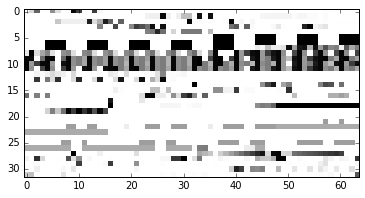

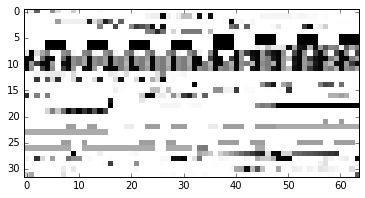

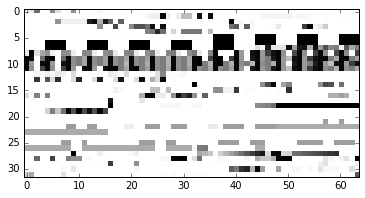

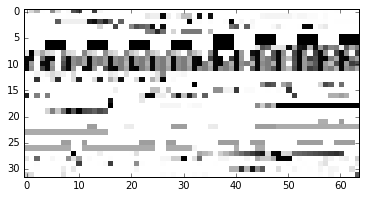

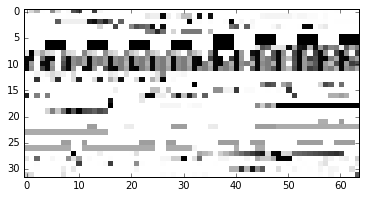

In [65]:
for _ in range(4):
    for _ in range(60):
        emu.step()
    visualize_ram(emu.get_ram())
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [93]:
for i in range(120):
    emu.step()

In [100]:
def play_movie(emu:Emu):
    # sanity hack, to make schour nothing is left in the buffer
    # prim_soc.recv(2**10)
    emu.play_beginning()
    emu.speed_mode("turbo")
    last_state = True
    while last_state:
        last_state = emu.play_movie()
        yield emu.get_ram()
        

for i in play_movie(emu):
    pass

In [107]:
first_recording = DataFrame.from_records(play_movie(emu))